In [3]:
import json
import numpy as np
from skimage.transform import resize
from time import sleep
import matplotlib.pyplot as plt

In [4]:
#Read information json:
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
PATH_VOLS = '/Datasets/PICAI_32x32x12/volumes/'
#read json

with open(PATH_JSON_INFO, 'r') as f:
    info = json.load(f)

In [1]:
#make a function that given a volume returns the center slice in x,y and z
def get_center_slices(vol):
    x,y,z = vol.shape
    return vol[(x-1)//2,:,:], vol[:,(y-1)//2,:], vol[:,:,(z-1)//2]

def resize2_32(slice):
    return resize(slice, (32,32), anti_aliasing=True)

def resize2_224(slice):
    return resize(slice, (224,224), anti_aliasing=True)

def get_spd(acts,type="gramm"):
    h,w,d = acts.shape
    vect_acts = acts.reshape(h*w,d)
    if type == "gramm":
        spd = vect_acts.T@vect_acts
    elif type == "corr":
        spd = np.corrcoef(vect_acts.T)
    elif type == "cov":
        spd = np.cov(vect_acts.T)
    return spd

In [1]:
#Using tensorflow and VGG9 describe the slices
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#Load the model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(32,32,3))

#Get the first pooling layer
model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block1_conv2').output)
model.summary()


2024-10-15 16:16:35.546528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 16:16:35.563266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 16:16:35.568338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 16:16:35.581121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


: 

In [22]:
PATH_SAVE = '/Datasets/PICAI_32x32x12/covs_vgg19/'
i = 0
long = len(info)
for key in info:
    vol1 = np.load(PATH_VOLS + key+ "_0000" + '.npy')
    vol2 = np.load(PATH_VOLS + key+ "_0001" + '.npy')
    vol3 = np.load(PATH_VOLS + key+ "_0002" + '.npy')

    #Standarize the volumes
    vol1 = (vol1 - vol1.mean()) / vol1.std()
    vol2 = (vol2 - vol2.mean()) / vol2.std()
    vol3 = (vol3 - vol3.mean()) / vol3.std()

    vol_list = [vol1, vol2, vol3]
    s1_list = []
    s2_list = []
    s3_list = []
    for vol in vol_list:
        s1,s2,s3 = get_center_slices(vol)
        s1 = resize2_32(s1)
        s2 = resize2_32(s2)

        #Repeat slices 3 times along 2 axis
        s1 = np.repeat(s1[:,:,np.newaxis], 3, axis=2)
        s2 = np.repeat(s2[:,:,np.newaxis], 3, axis=2)
        s3 = np.repeat(s3[:,:,np.newaxis], 3, axis=2)
        s1_list.append(s1)
        s2_list.append(s2)
        s3_list.append(s3)

    #Stack slices list over first axis
    s1_l = np.stack(s1_list, axis=0)#shape(3 modalities,32,32,3 (RGB))
    s2_l = np.stack(s2_list, axis=0)
    s3_l = np.stack(s3_list, axis=0)

    s1_acts = model.predict(s1_l,verbose=0)
    s2_acts = model.predict(s2_l,verbose=0)
    s3_acts = model.predict(s3_l,verbose=0)

    s1_reordered = s1_acts.transpose(1,2,3,0).reshape(32,32,-1) #shape(32,32,3*64) = (32,32,192) -> COrrelacionando para un slice las 3 modalidades
    s2_reordered = s2_acts.transpose(1,2,3,0).reshape(32,32,-1)
    s3_reordered = s3_acts.transpose(1,2,3,0).reshape(32,32,-1)

    mat = "cov"
    s1_spd = get_spd(s1_reordered,mat)
    s2_spd = get_spd(s2_reordered,mat)
    s3_spd = get_spd(s3_reordered,mat)

    #Save spds as .npy
    np.save(PATH_SAVE + key + "_s1" + ".npy", s1_spd)
    np.save(PATH_SAVE + key + "_s2" + ".npy", s2_spd)
    np.save(PATH_SAVE + key + "_s3" + ".npy", s3_spd)
    
    i = i+1
    #Print loading bar
    print(f"Process {i}/{long}  - ({round((i/long)*100,3)}% done)", end="\r")
    sleep(0.05)

# GEt slices only

In [4]:
PATH_VOLS

'/Datasets/PICAI_32x32x12/volumes/'

In [5]:
PATH_SAVE = '/Datasets/PICAI_32x32x12/slices/'
i = 0
long = len(info)
s_names_list = []
for key in info:

    name1 = key + "_0000"
    name2 = key + "_0001"
    name3 = key + "_0002"
    
    vol1 = np.load(PATH_VOLS + name1 + '.npy')
    vol2 = np.load(PATH_VOLS + name2 + '.npy')
    vol3 = np.load(PATH_VOLS + name3 + '.npy')

    #Standarize the volumes
    vol1 = (vol1 - vol1.mean()) / vol1.std()
    vol2 = (vol2 - vol2.mean()) / vol2.std()
    vol3 = (vol3 - vol3.mean()) / vol3.std()

    vol_list = [vol1, vol2, vol3]
    names_list = [name1, name2, name3]

    for vol,name in zip(vol_list,names_list):
        s1,s2,s3 = get_center_slices(vol)
        s1 = resize2_32(s1)
        s2 = resize2_32(s2)

        #Save slice with identiffier si
        s1_name = PATH_SAVE + name + "_s0" + ".npy"
        s2_name = PATH_SAVE + name + "_s1" + ".npy"
        s3_name = PATH_SAVE + name + "_s2" + ".npy"

        np.save(s1_name, s1)
        np.save(s2_name, s2)
        np.save(s3_name, s3)

        s_names_list = s_names_list + [s1_name, s2_name, s3_name]
    break
    i = i+1
    #Print loading bar
    print(f"Process {i}/{long}  - ({round((i/long)*100,3)}% done)", end="\r")
    sleep(0.05)

In [7]:
# Extract keys where case_ISUP >= 4
keys_with_case_ISUP_ge_4 = [key for key, value in info.items() if value.get('case_ISUP', 0) >= 4]

# Print the result
print(keys_with_case_ISUP_ge_4)

['10078_1000078', '11357_1001380', '10322_1000328', '10523_1000533', '10957_1000976', '10730_1000746', '10342_1000348', '10570_1000582', '10241_1000245', '10942_1000961', '11299_1001322', '10688_1000704', '10808_1000824', '10339_1000345', '10825_1000841', '11462_1001486', '11100_1001123', '10368_1000374', '11447_1001471', '10216_1000220', '10168_1000171', '10970_1000989', '10607_1000621', '10211_1000215', '10833_1000849', '11428_1001452', '11051_1001071', '10234_1000238', '11475_1001499', '10868_1000884', '11208_1001231', '10463_1000471', '11174_1001197', '11130_1001153', '11002_1001021', '11181_1001204', '11375_1001398', '11194_1001217']


In [8]:
# Initialize an empty list to store slices for plotting
slices_list = []
i = 0
long = len(info)

for key in keys_with_case_ISUP_ge_4:
    name1 = key + "_0000"
    name2 = key + "_0001"
    name3 = key + "_0002"
    
    vol1 = np.load(PATH_VOLS + name1 + '.npy')
    vol2 = np.load(PATH_VOLS + name2 + '.npy')
    vol3 = np.load(PATH_VOLS + name3 + '.npy')

    # Standardize the volumes
    vol1 = (vol1 - vol1.mean()) / vol1.std()
    vol2 = (vol2 - vol2.mean()) / vol2.std()
    vol3 = (vol3 - vol3.mean()) / vol3.std()

    vol_list = [vol1, vol2, vol3]
    names_list = [name1, name2, name3]

    for vol, name in zip(vol_list, names_list):
        # Get slices
        s1, s2, s3 = get_center_slices(vol)
        # Resize to 32x32 if needed
        s1 = resize2_32(s1)
        s2 = resize2_32(s2)
        
        # Instead of saving slices, append them to the slices_list
        slices_list.append((name, s1, s2, s3))

    i = i + 1
    # Print loading bar
    print(f"Process {i}/{long}  - ({round((i/long)*100,3)}% done)", end="\r")
    sleep(0.05)


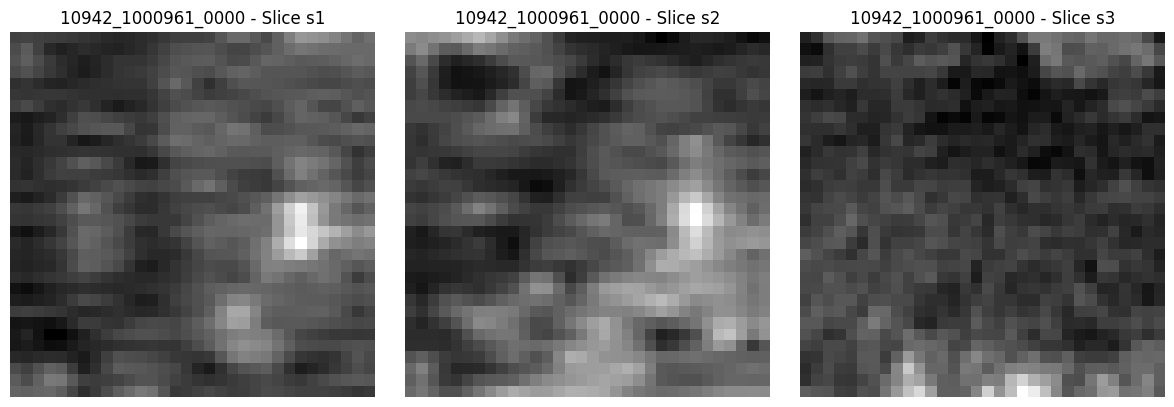

In [31]:
import matplotlib.pyplot as plt

# Define the function to plot the slices
def plot_slices(key, modality, slices_list):
    # Search for the slices corresponding to the key and modality
    for name, s1, s2, s3 in slices_list:
        if name == key + "_" + modality:
            # Create a figure with 3 subplots for the slices
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            
            # Plot the three slices
            axes[0].imshow(s1, cmap='gray')
            axes[0].set_title(f"{name} - Slice s1")
            axes[0].axis('off')
            
            axes[1].imshow(s2, cmap='gray')
            axes[1].set_title(f"{name} - Slice s2")
            axes[1].axis('off')
            
            axes[2].imshow(s3, cmap='gray')
            axes[2].set_title(f"{name} - Slice s3")
            axes[2].axis('off')
            
            # Show the plot
            plt.tight_layout()
            plt.show()
            return

# Plot the slices for the first key
key = keys_with_case_ISUP_ge_4[9]
modality = "0000"
plot_slices(key, modality, slices_list)